<a href="https://colab.research.google.com/github/justatma/Bayesian_Marketing/blob/main/Savvly_Bayesian_Ads_ver_2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# @title Setup: Install Necessary Libraries
# Install necessary libraries
!pip install pymc>=5.0 arviz pandas numpy matplotlib seaborn --quiet

In [ ]:
# @title Setup: Import Libraries
import pymc as pm
import arviz as az
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Set ArviZ style for nicer plots
az.style.use("arviz-darkgrid")

print(f"Running on PyMC v{pm.__version__}")
print(f"Running on ArviZ v{az.__version__}")

Running on PyMC v5.22.0
Running on ArviZ v0.21.0



## 1. Configuration and Data Loading

### 1.1. Setting Run Parameters (Configuration Cell Below*   *Note:* If running multiple analyses on the same day, use suffixes like `"YYYY-MM-DD-01")

Before loading data, define key parameters for this specific analysis run in the **next code cell**. This makes`, `"YYYY-MM-DD-02"`. (Add -0X for multiple runs on same day.)

2.  **Verify `PROJECT_DIR`:**
    * This notebook is reusable. **You only need to update the `RUN_DATE_STR` and verify the `PROJECT_   Confirm this variable points to your **main project folder** in Google Drive (the one containing the `1. CodeDIR` in the code cell below for each new run.**

*   **Run Date (`RUN_DATE_STR`):** Notebooks`, `2. Data`, `3. Reports`, etc. subfolders).
    *   *Example:* `PROJECT Identifies the data period (e.g., "2023-11-30"). Used for_DIR = "/content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)"`

** naming files.
*   **Project Directory (`PROJECT_DIR`):** The main Google Drive folder containing subfolders likeAutomatic Path Construction (Verify in Code Cell Output):**

*   The code cell will automatically construct the full paths for `2. Data`, `3. Reports`, etc.
*   **File Paths (Automatic):** Based on the Run:
    *   **Input Data:** (`INPUT_CSV`) - Checks in the `2. Data` sub Date and Project Directory, the code automatically constructs the full paths to the input data CSV and the output report/trace files.
folder.
    *   **Output Report:** (`OUTPUT_REPORT_HTML`) - Saves to the `3.*   **Analysis Parameters:** Sets consistent values for analysis (like HDI level, CPA target, ROAS threshold) and M Reports` subfolder.
    *   **Output Traces:** (`OUTPUT_TRACE_...`) - Saves to the `4. Traces` subfolder.
*   Review the printed output from the configuration code cell to ensureCMC diagnostic checks.

### 1.2. Loading and Preparing Data (Code Cell Below)

After configuration these paths look correct before running the rest of the notebook.

**Analysis Parameters (Review in Code Cell):**

*   Confirm, a later code cell (`# @title Data: Load and Prepare...`) will:
1.  Load the specific CSV the settings for `HDI_PROB`, `ROAS_THRESHOLD`, `CPA_TARGET`, `R_HAT_ file identified by the `INPUT_CSV` path (constructed in the config cell).
2.  Perform necessary cleaning:THRESHOLD`, and `ESS_THRESHOLD` meet your current needs. These usually change less often than the date.

---
 renaming columns, converting data types, handling missing values.
3.  Display the prepared DataFrame (`df`) that the Bayesian models will use.

In [ ]:
# @title Configuration: Set Run Parameters and File Paths

# --- STEP 1: Mount Google Drive (if not already mounted) ---
# Ensures Drive is accessible before defining paths based on it
from google.colab import drive
try:
    drive.mount('/content/drive', force_remount=True)
    print("Google Drive mounted successfully.")
except Exception as e:
    print(f"ERROR mounting Google Drive: {e}")
    raise SystemExit("Stopping: Google Drive could not be mounted.")

# --- STEP 2: DEFINE CORE RUN PARAMETERS (!!! CHANGE THESE EACH RUN !!!) ---

# 2a. The Date String for the CURRENT analysis period (used in filenames)
#     Use YYYY-MM-DD format. This should match the data file you're loading.
RUN_DATE_STR = "2023-11-30"  # <--- UPDATE THIS FOR EACH NEW RUN !!!

# 2b. Base Project Directory in Google Drive
#     This is the main folder containing your 'Data', 'Reports', 'Traces' etc. subfolders
#     REPLACE THE EXAMPLE BELOW WITH YOUR ACTUAL PROJECT FOLDER PATH
PROJECT_DIR = "/content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)" # <--- UPDATE THIS PATH !!!

# --- STEP 3: DEFINE FILE PATHS (These are constructed automatically) ---

# Input Data Path (Assumes data CSV is named like 'ad_data_YYYY-MM-DD.csv')
INPUT_CSV = f"{PROJECT_DIR}/2. Data/ad_data_{RUN_DATE_STR}.csv" # Adjusted subfolder name based on your structure

# Output Report Path (HTML version)
OUTPUT_REPORT_HTML = f"{PROJECT_DIR}/3. Reports/Report_{RUN_DATE_STR}.html" # Adjusted subfolder name

# Output Trace File Paths (Optional but recommended for saving MCMC results)
OUTPUT_TRACE_CTR = f"{PROJECT_DIR}/4. Traces/ctr_trace_{RUN_DATE_STR}.nc" # Adjusted subfolder name
OUTPUT_TRACE_CVR = f"{PROJECT_DIR}/4. Traces/cvr_trace_{RUN_DATE_STR}.nc" # Adjusted subfolder name (stores CVR & CPA)
OUTPUT_TRACE_ROAS = f"{PROJECT_DIR}/4. Traces/roas_trace_{RUN_DATE_STR}.nc" # Adjusted subfolder name

# --- STEP 4: DEFINE ANALYSIS PARAMETERS ---
# These might not change every run, but good to have them here

# Confidence level for HDI intervals
HDI_PROB = 0.95

# Thresholds for reporting/analysis
ROAS_THRESHOLD = 1.0
CPA_TARGET = 50.0

# Thresholds for MCMC diagnostics in the report function
R_HAT_THRESHOLD = 1.05
ESS_THRESHOLD = 400


# --- Print configured paths for verification ---
print("-" * 30)
print(f"Configuration for Run Date: {RUN_DATE_STR}")
print(f"Project Directory: {PROJECT_DIR}")
print(f"Input Data CSV: {INPUT_CSV}")
print(f"Output Report HTML: {OUTPUT_REPORT_HTML}")
print(f"Output CTR Trace: {OUTPUT_TRACE_CTR}")
print(f"Output CVR/CPA Trace: {OUTPUT_TRACE_CVR}")
print(f"Output ROAS Trace: {OUTPUT_TRACE_ROAS}")
print(f"CPA Target: ${CPA_TARGET:.2f}")
print("-" * 30)

Mounted at /content/drive
Google Drive mounted successfully.
------------------------------
Configuration for Run Date: 2023-11-30
Project Directory: /content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)
Input Data CSV: /content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)/2. Data/ad_data_2023-11-30.csv
Output Report HTML: /content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)/3. Reports/Report_2023-11-30.html
Output CTR Trace: /content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)/4. Traces/ctr_trace_2023-11-30.nc
Output CVR/CPA Trace: /content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)/4. Traces/cvr_trace_2023-11-30.nc
Output ROAS Trace: /content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)/4. Traces/roas_trace_2023-11-30.nc
CPA Target: $50.00
------------------------------


In [ ]:
# @title Data: Load and Prepare Data (from CSV or Sample)

# --- Option 1: Load Data from CSV (DEFAULT) ---
# Assumes INPUT_CSV is defined in the Configuration Cell above
print(f"Attempting to load data from: {INPUT_CSV}")
try:
    df_raw = pd.read_csv(INPUT_CSV) # Load into a temporary variable first
    print("CSV data loaded successfully.")
    print("Raw data head:")
    print(df_raw.head())

    # --- Clean and Standardize Data ---
    print("\n--- Cleaning and Standardizing ---")

    # 1. Rename columns (Use the EXACT names from the CSV export)
    rename_dict = {
        # === !!! UPDATE THIS DICTIONARY BASED ON YOUR CSV !!! ===
        'Ad Set Name': 'campaign_id',     # Example
        'Impr.': 'impressions',           # Example
        'Link Clicks': 'clicks',          # Example
        'Website Purchases': 'conversions', # Example - use YOUR specific conversion event name
        'Amount Spent (USD)': 'spend',     # Example
        'Purchase Value': 'revenue'         # Example
        # ========================================================
    }
    # Filter columns to keep only those we need AND that exist in the raw data
    columns_to_keep = [col for col in rename_dict.keys() if col in df_raw.columns]
    missing_expected_cols = [col for col in rename_dict.keys() if col not in df_raw.columns]
    if missing_expected_cols:
         print(f"WARNING: Expected columns not found in CSV: {missing_expected_cols}")

    df = df_raw[columns_to_keep].copy() # Select only the columns we need and can rename
    df.rename(columns=rename_dict, inplace=True)
    print(f"Renamed columns: {df.columns.tolist()}")


    # 2. Convert data types (handle errors like '$' or ',')
    numeric_cols = ['impressions', 'clicks', 'conversions', 'spend', 'revenue']
    for col in numeric_cols:
        if col in df.columns:
            #print(f"Converting column: {col}") # Optional: uncomment for detailed logs
            if df[col].dtype == 'object': # Check if it's not already numeric
               df[col] = df[col].astype(str).str.replace(r'[$,]', '', regex=True)
            df[col] = pd.to_numeric(df[col], errors='coerce') # Coerce errors to NaN

    # 3. Handle Missing Values
    essential_cols = ['campaign_id', 'impressions', 'clicks', 'spend'] # Define essential columns
    rows_before = len(df)
    df.dropna(subset=[col for col in essential_cols if col in df.columns], inplace=True) # Drop only if essential cols exist
    rows_after = len(df)
    if rows_before > rows_after:
        print(f"Dropped {rows_before - rows_after} rows due to missing essential data ({essential_cols}).")

    # Fill NaNs created during numeric conversion or originally present
    # Fill remaining numeric NaNs with 0 (adjust if different logic is needed)
    for col in numeric_cols:
        if col in df.columns and df[col].isnull().any():
            print(f"Filling NaN values in '{col}' with 0.")
            df[col].fillna(0, inplace=True)

    # Ensure integer types where appropriate (after filling NaNs)
    for col in ['impressions', 'clicks', 'conversions']:
         if col in df.columns:
              df[col] = df[col].astype(int)

    print("\n--- Finished Cleaning ---")

except FileNotFoundError:
    print(f"ERROR: File not found at {INPUT_CSV}.")
    print("!!! USING SAMPLE DATA INSTEAD !!!")
    # --- Option 2: Use Sample Data (Fallback / Testing) ---
    # (Keep the sample data definition commented out unless needed for testing)
    # print("\n--- Using Sample Data ---")
    data = { # Using the original sample data definition
        'campaign_id': ['Campaign_A', 'Campaign_B', 'Campaign_C', 'Campaign_D'],
        'impressions': [10000, 12500, 8000, 15000],
        'clicks': [200, 225, 170, 330],
        'conversions': [5, 8, 4, 12],
        'spend': [150.0, 180.0, 120.0, 250.0],
        'revenue': [350.0, 550.0, 200.0, 750.0]
    }
    df = pd.DataFrame(data)
    # Sample data is assumed clean, no further processing needed here for it.

except Exception as e:
    print(f"ERROR loading or processing data: {e}")
    raise SystemExit("Stopping due to data loading/processing error.")


# --- Calculate observed metrics (for reference only) ---
# Do this AFTER df is defined by either CSV or Sample data
if 'conversions' in df.columns and 'clicks' in df.columns:
    df['observed_cvr'] = df['conversions'] / df['clicks'].replace(0, np.nan)
if 'revenue' in df.columns and 'spend' in df.columns:
    df['observed_roas'] = df['revenue'] / df['spend'].replace(0, np.nan)


# --- Final Output ---
print("\nFinal Prepared Data Overview:")
print(df.head())
print("\nData Types:")
print(df.info())

Attempting to load data from: /content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)/2. Data/ad_data_2023-11-30.csv
ERROR: File not found at /content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)/2. Data/ad_data_2023-11-30.csv.
!!! USING SAMPLE DATA INSTEAD !!!

Final Prepared Data Overview:
  campaign_id  impressions  clicks  conversions  spend  revenue  observed_cvr  \
0  Campaign_A        10000     200            5  150.0    350.0      0.025000   
1  Campaign_B        12500     225            8  180.0    550.0      0.035556   
2  Campaign_C         8000     170            4  120.0    200.0      0.023529   
3  Campaign_D        15000     330           12  250.0    750.0      0.036364   

   observed_roas  
0       2.333333  
1       3.055556  
2       1.666667  
3       3.000000  

Data Types:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4 entries, 0 to 3
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         -

## 2. Click-Through Rate (CTR) Analysis

### 2.1. Bayesian Model for CTR

We model the Click-Through Rate (CTR), which is `Clicks / Impressions`. We assume the number of clicks follows a Binomial distribution given the number of impressions and the underlying CTR.

We use a **weakly informative prior** (Beta(1, 1), equivalent to Uniform(0, 1)) for the CTR of each campaign. This means we initially assume all CTRs between 0% and 100% are equally likely, letting the observed data strongly influence the final estimate.

The MCMC sampler explores the possible values for each campaign's CTR based on the data and the prior.

In [ ]:
# @title Model: Define and Sample CTR Model
# --- Bayesian Model for Click-Through Rate (CTR) ---
# Model: Clicks ~ Binomial(n=impressions, p=CTR)
# Prior for CTR: CTR ~ Beta(alpha, beta)

coords = {"campaign": df['campaign_id'].values}

with pm.Model(coords=coords) as ctr_model:
    # Data containers
    impressions_data = pm.Data("impressions_data", df['impressions'].values, mutable=True)
    clicks_data = pm.Data("clicks_data", df['clicks'].values, mutable=True)

    # Prior for CTR for each campaign (Weakly Informative: Beta(1,1))
    ctr_prior = pm.Beta("ctr", alpha=1.0, beta=1.0, dims="campaign")

    # Likelihood of observing the clicks given impressions and CTR
    observed_clicks = pm.Binomial("observed_clicks",
                                  n=impressions_data,
                                  p=ctr_prior,
                                  observed=clicks_data,
                                  dims="campaign")

    # --- Run the MCMC Sampler ---
    print("Sampling CTR model...")
    ctr_trace = pm.sample(draws=2000, tune=1000, chains=4, target_accept=0.9)
    print("Sampling complete.")

    # --- REMOVE this summary - it's redundant with the analysis cell ---
    # az.summary(ctr_trace, var_names=["ctr"])

/usr/local/lib/python3.11/dist-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


Sampling CTR model...


Output()

Sampling complete.


### 2.2. CTR Results and Interpretation

Here we analyze the results from the CTR model.

*   **Summary Table:** Shows the key statistics for each campaign's estimated CTR posterior distribution:
    *   `mean`: The average estimated CTR (our best single guess).
    *   `sd`: Standard deviation, indicating the uncertainty or spread.
    *   `hdi_...%`: The Highest Density Interval (Credible Interval). We are 95% confident the true CTR lies within this range.
    *   Diagnostics (`mcse`, `ess`, `r_hat`): Should indicate good MCMC convergence (r_hat ≈ 1.0, high ESS).
*   **Posterior Plots:** Visualize the probability distribution for each campaign's CTR. Narrower peaks mean more certainty.
*   **Comparison Probabilities:** Calculate the likelihood that one campaign's true CTR is higher than another's.
*   **Difference Plot:** Visualizes the distribution of the difference between two campaigns (e.g., CTR_A - CTR_B). If most of the distribution is above zero, A is likely better.


CTR Posterior Summary (95% HDI):
                  mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
ctr[Campaign_A]  0.020  0.001     0.017      0.023        0.0      0.0   
ctr[Campaign_B]  0.018  0.001     0.016      0.020        0.0      0.0   
ctr[Campaign_C]  0.021  0.002     0.018      0.025        0.0      0.0   
ctr[Campaign_D]  0.022  0.001     0.020      0.024        0.0      0.0   

                 ess_bulk  ess_tail  r_hat  
ctr[Campaign_A]    9397.0    5702.0    1.0  
ctr[Campaign_B]    7789.0    5113.0    1.0  
ctr[Campaign_C]    9810.0    6279.0    1.0  
ctr[Campaign_D]    8008.0    6359.0    1.0  

Plotting CTR Posteriors...


<ipython-input-6-71dce1bb79ca>:15: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


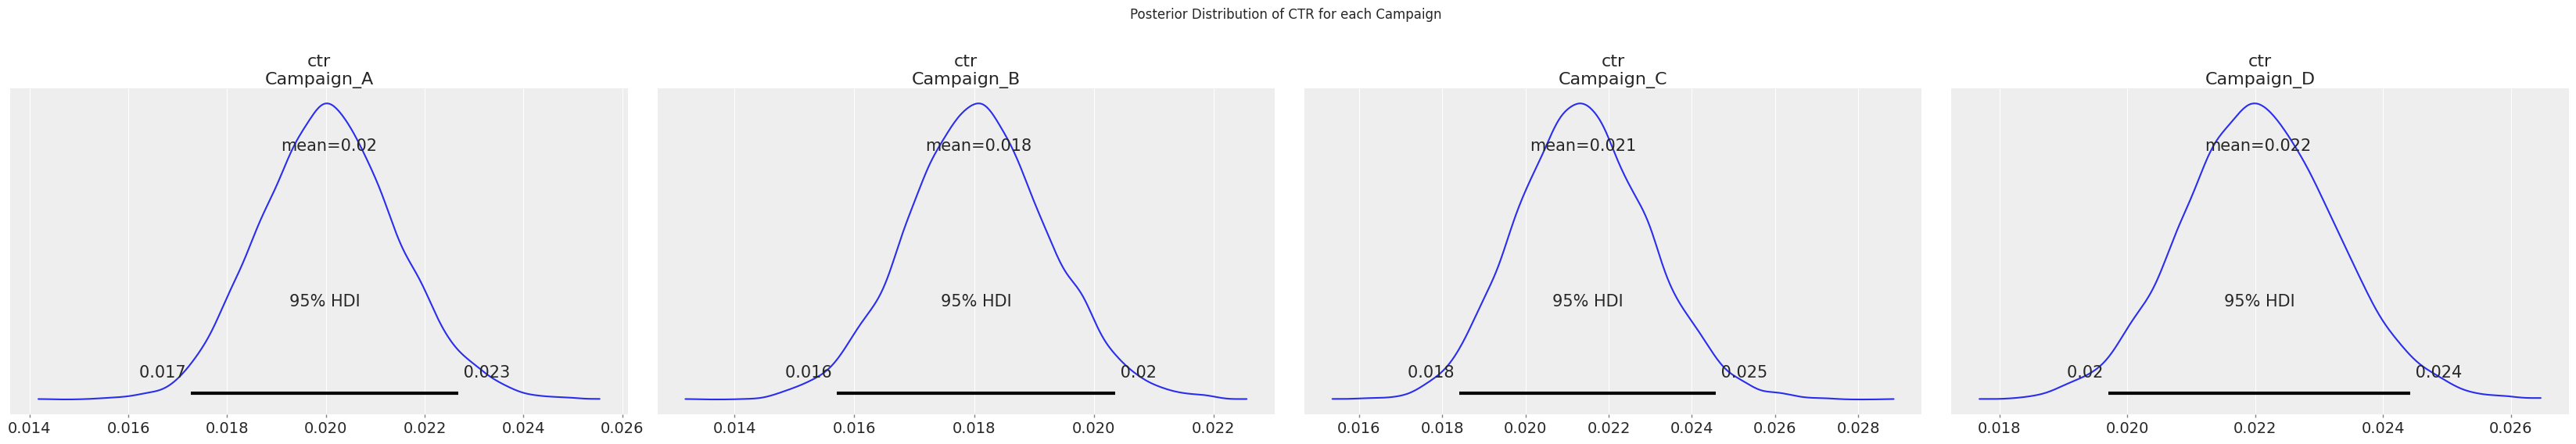


CTR Comparison Probabilities:
* Probability Campaign A CTR > Campaign B CTR: 86.76%
* Probability Campaign D CTR > Campaign A CTR: 85.70%

Plotting Difference in CTR (A vs B)...


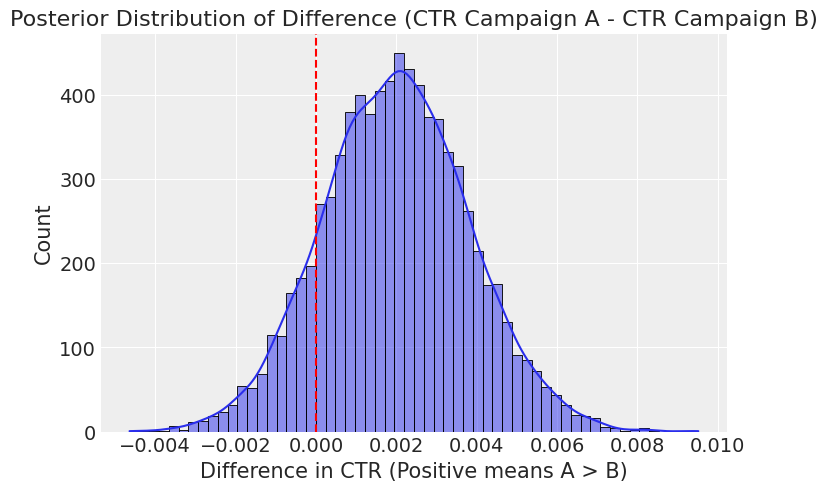

In [ ]:
# @title Analysis: CTR Results Summary and Plots

# --- Analyze CTR Results ---
# REMOVE: print("\n--- CTR Analysis ---") # Replaced by Markdown header

# 1. Summary Statistics
print("\nCTR Posterior Summary (95% HDI):") # Keep this print for clarity before table
ctr_summary = az.summary(ctr_trace, var_names=["ctr"], hdi_prob=0.95, kind='all') # Use kind='all' to ensure diagnostics
print(ctr_summary)

# 2. Visualize Posterior Distributions
print("\nPlotting CTR Posteriors...") # Keep print statement
az.plot_posterior(ctr_trace, var_names=["ctr"], hdi_prob=0.95)
plt.suptitle("Posterior Distribution of CTR for each Campaign", y=1.02) # Add title
plt.tight_layout()
plt.show()

# 3. Compare Campaigns (Example: Probability Campaign A CTR > Campaign B CTR)
print("\nCTR Comparison Probabilities:") # Add clarifying print
ctr_samples = ctr_trace.posterior['ctr']
ctr_a_samples = ctr_samples.sel(campaign='Campaign_A').values.flatten()
ctr_b_samples = ctr_samples.sel(campaign='Campaign_B').values.flatten()
ctr_d_samples = ctr_samples.sel(campaign='Campaign_D').values.flatten()

diff_a_b = ctr_a_samples - ctr_b_samples
prob_a_gt_b = (diff_a_b > 0).mean()
print(f"* Probability Campaign A CTR > Campaign B CTR: {prob_a_gt_b:.2%}") # Use bullet points

diff_d_a = ctr_d_samples - ctr_a_samples
prob_d_gt_a = (diff_d_a > 0).mean()
print(f"* Probability Campaign D CTR > Campaign A CTR: {prob_d_gt_a:.2%}") # Use bullet points
# Add other comparisons if desired

# Visualize the difference
print("\nPlotting Difference in CTR (A vs B)...") # Keep print statement
sns.histplot(diff_a_b, kde=True)
plt.axvline(0, color='red', linestyle='--')
plt.title("Posterior Distribution of Difference (CTR Campaign A - CTR Campaign B)") # More descriptive title
plt.xlabel("Difference in CTR (Positive means A > B)") # Clearer label
plt.ylabel("Count") # Add Y label
plt.show()

In [ ]:
# @title Model: Define and Sample CVR Model
# --- Bayesian Model for Conversion Rate (CVR) ---
# Model: Conversions ~ Binomial(n=clicks, p=CVR)
# Prior for CVR: CVR ~ Beta(alpha, beta)

# Filter out campaigns with 0 clicks if using clicks as the base
df_cvr = df[df['clicks'] > 0].copy()
# Check if df_cvr is empty, handle if necessary (though unlikely with sample data)
if df_cvr.empty:
    print("WARNING: No campaigns with clicks > 0 found. Skipping CVR analysis.")
    cvr_trace = None # Set trace to None to prevent errors later
else:
    coords_cvr = {"campaign_cvr": df_cvr['campaign_id'].values}

    with pm.Model(coords=coords_cvr) as cvr_model:
        # Data containers
        clicks_data_cvr = pm.Data("clicks_data_cvr", df_cvr['clicks'].values, mutable=True)
        conversions_data = pm.Data("conversions_data", df_cvr['conversions'].values, mutable=True)

        # Prior for CVR for each campaign (Weakly Informative: Beta(1,1))
        cvr_prior = pm.Beta("cvr", alpha=1.0, beta=1.0, dims="campaign_cvr")

        # Likelihood
        observed_conversions = pm.Binomial("observed_conversions",
                                          n=clicks_data_cvr,
                                          p=cvr_prior,
                                          observed=conversions_data,
                                          dims="campaign_cvr")

        # --- Run the MCMC Sampler ---
        print("Sampling CVR model...")
        cvr_trace = pm.sample(draws=2000, tune=1000, chains=4, target_accept=0.9)
        print("Sampling complete.")

        # --- REMOVE this summary ---
        # az.summary(cvr_trace, var_names=["cvr"])

/usr/local/lib/python3.11/dist-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


Sampling CVR model...


Output()

Sampling complete.


**Interpretation Notes (CTR):**

*   *(Copy the CTR interpretation bullet points from the `report_text_with_cpa` summary here, e.g., "* Campaign_A: Estimated CTR is 2.00% (95% likely between 1.70% and 2.30%)")*
*   *(Copy the comparison probabilities summary, e.g., "* Probability Campaign_A CTR > Campaign_B CTR: 86.4%")*
*   Discuss the implications: Campaign D appears strongest, A is likely better than B, etc. Relate the probabilities to decision confidence levels.

## 3. Conversion Rate (CVR) Analysis

### 3.1. Bayesian Model for CVR

Next, we model the Conversion Rate (CVR), defined here as `Conversions / Clicks`. (Note: Ensure this definition matches the stakeholder's expectation). We assume the number of conversions follows a Binomial distribution given the number of clicks and the underlying CVR.

Again, we use a **weakly informative prior** (Beta(1, 1)) for each campaign's CVR.

### 3.2. CVR Results and Interpretation

We analyze the CVR results similarly to CTR. Expect wider HDI ranges here, as conversions are typically less frequent than clicks, leading to more uncertainty.


CVR Posterior Summary (95% HDI):
                  mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
cvr[Campaign_A]  0.030  0.012     0.009      0.053        0.0      0.0   
cvr[Campaign_B]  0.040  0.013     0.015      0.065        0.0      0.0   
cvr[Campaign_C]  0.029  0.013     0.006      0.054        0.0      0.0   
cvr[Campaign_D]  0.039  0.011     0.020      0.060        0.0      0.0   

                 ess_bulk  ess_tail  r_hat  
cvr[Campaign_A]    7666.0    4763.0    1.0  
cvr[Campaign_B]    8463.0    5564.0    1.0  
cvr[Campaign_C]    7744.0    4609.0    1.0  
cvr[Campaign_D]    8739.0    5823.0    1.0  

Plotting CVR Posteriors...


<ipython-input-8-dedb7df1a3a1>:17: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


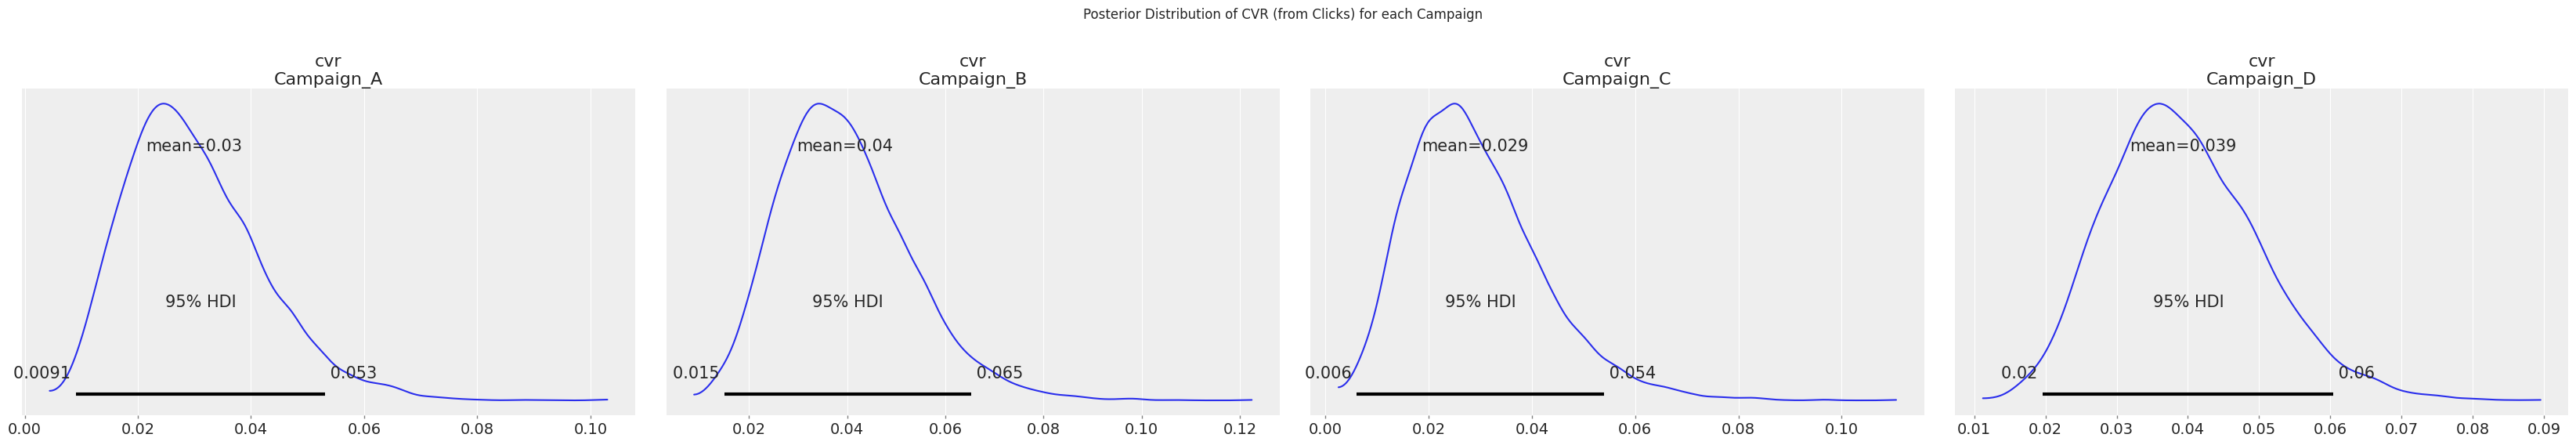


CVR Comparison Probabilities:
* Probability Campaign B CVR > Campaign A CVR: 71.41%

Plotting Difference in CVR (B vs A)...


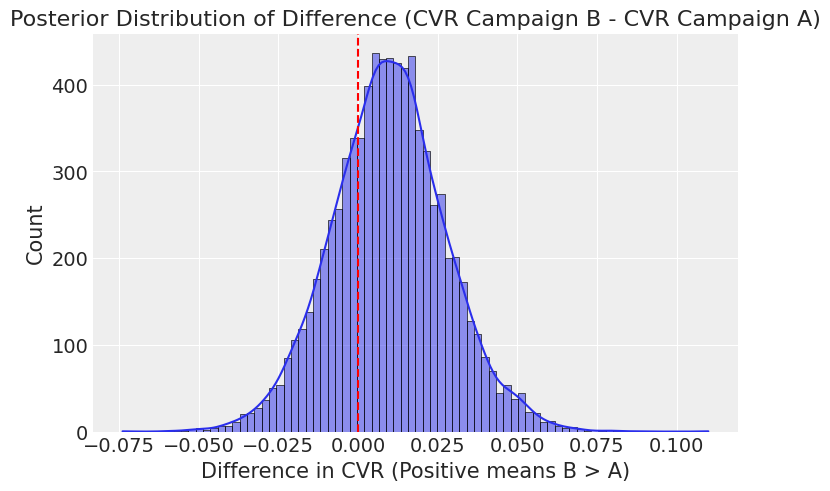

In [ ]:
# @title Analysis: CVR Results Summary and Plots

# --- Analyze CVR Results ---
# Check if cvr_trace exists and is not None before proceeding
if 'cvr_trace' in locals() and cvr_trace is not None:
    # REMOVE: print("\n--- CVR Analysis ---") # Replaced by Markdown

    # 1. Summary Statistics
    print("\nCVR Posterior Summary (95% HDI):") # Keep print
    cvr_summary = az.summary(cvr_trace, var_names=["cvr"], hdi_prob=0.95, kind='all') # Use kind='all'
    print(cvr_summary)

    # 2. Visualize Posterior Distributions
    print("\nPlotting CVR Posteriors...") # Keep print
    az.plot_posterior(cvr_trace, var_names=["cvr"], hdi_prob=0.95)
    plt.suptitle("Posterior Distribution of CVR (from Clicks) for each Campaign", y=1.02) # Clarify title
    plt.tight_layout()
    plt.show()

    # 3. Compare Campaigns
    print("\nCVR Comparison Probabilities:") # Add print
    cvr_samples = cvr_trace.posterior['cvr']
    cvr_a_samples = cvr_samples.sel(campaign_cvr='Campaign_A').values.flatten()
    cvr_b_samples = cvr_samples.sel(campaign_cvr='Campaign_B').values.flatten()
    # Add others if needed for specific comparisons

    diff_b_a_cvr = cvr_b_samples - cvr_a_samples
    prob_b_gt_a_cvr = (diff_b_a_cvr > 0).mean()
    print(f"* Probability Campaign B CVR > Campaign A CVR: {prob_b_gt_a_cvr:.2%}") # Use bullet points
    # Add other comparisons if desired

    # Visualize the difference
    print("\nPlotting Difference in CVR (B vs A)...") # Keep print
    sns.histplot(diff_b_a_cvr, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title("Posterior Distribution of Difference (CVR Campaign B - CVR Campaign A)") # Descriptive title
    plt.xlabel("Difference in CVR (Positive means B > A)") # Clearer label
    plt.ylabel("Count") # Add Y label
    plt.show()
else:
    print("\nCVR Analysis skipped because cvr_trace was not generated (likely no clicks).")

**Interpretation Notes (CVR):**

*   *(Copy the CVR interpretation bullet points from the `report_text_with_cpa` summary here)*
*   *(Copy the CVR comparison probabilities summary)*
*   Discuss the wider uncertainty (HDI ranges). Discuss which campaigns are likely better at converting *clicks* and the confidence level. Compare/contrast with CTR findings (e.g., Campaign A has good CTR vs B, but B has better CVR vs A).

## 4. Cost Per Acquisition (CPA) Analysis

### 4.1. Deriving the CPA Posterior

Cost Per Acquisition (CPA) is a key metric: `Spend / Conversions`. We don't model it directly but *derive* its posterior distribution using the results from our CVR model.

Specifically, we calculate `CPA ≈ Spend / (Clicks * CVR)` for *each sample* in the CVR posterior distribution. This gives us a full probability distribution for CPA, allowing us to estimate uncertainty and compare campaigns.

In [ ]:
# @title Calculation: Derive CPA Posterior Distribution
# --- Calculate CPA Posterior Distribution ---
# CPA = Spend / Conversions = Spend / (Clicks * CVR_posterior)

# Ensure cvr_trace and df_cvr exist from previous cells
if 'cvr_trace' in locals() and cvr_trace is not None and 'df_cvr' in locals() and not df_cvr.empty:
    print("Calculating CPA posterior distribution...")

    # Get the posterior samples for CVR
    cvr_posterior_samples = cvr_trace.posterior['cvr']

    # Prepare Spend and Clicks data, aligning with the CVR trace coordinates
    campaign_coords_cvr = cvr_trace.posterior.coords['campaign_cvr'].values
    spend_aligned = df_cvr.set_index('campaign_id').loc[campaign_coords_cvr]['spend'].to_xarray().rename({'campaign_id': 'campaign_cvr'})
    clicks_aligned = df_cvr.set_index('campaign_id').loc[campaign_coords_cvr]['clicks'].to_xarray().rename({'campaign_id': 'campaign_cvr'})

    # Calculate CPA for each posterior sample
    epsilon = 1e-10
    cpa_posterior_samples = spend_aligned / (clicks_aligned * cvr_posterior_samples + epsilon)

    # Add the calculated CPA samples as a new variable to the posterior group
    cvr_trace.posterior['cpa'] = cpa_posterior_samples
    cvr_trace.posterior['cpa'].attrs['long_name'] = 'Cost Per Acquisition (Derived)'
    cvr_trace.posterior['cpa'].attrs['description'] = 'Calculated as Spend / (Clicks * CVR_posterior)'

    print("CPA posterior samples added to cvr_trace.")

    # --- Analyze CPA Results (Moved analysis to separate cell) ---
    # REMOVE ALL ANALYSIS CODE FROM THIS CELL (summary, plots, comparisons)
    # It will be done in the next cell.

elif 'cvr_trace' not in locals() or cvr_trace is None:
    print("Skipping CPA calculation: cvr_trace object not found.")
else: # df_cvr might be empty
     print("Skipping CPA calculation: No campaigns with clicks > 0 in df_cvr.")

Calculating CPA posterior distribution...
CPA posterior samples added to cvr_trace.


### 4.2. CPA Results and Interpretation

Now we analyze the derived CPA distribution. Remember, **lower CPA is generally better**. We look at the estimated average CPA, the uncertainty (HDI), the probability of being below a target CPA, and the probability that one campaign is genuinely more cost-effective than another.


CPA Posterior Summary (95% HDI):
                  mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  mcse_sd  \
cpa[Campaign_A]  29.96  14.54     10.53      57.76       0.19     0.36   
cpa[Campaign_B]  22.74   8.59      9.92      40.01       0.11     0.16   
cpa[Campaign_C]  30.56  18.73      8.41      61.66       0.28     0.88   
cpa[Campaign_D]  20.81   6.17     11.06      33.12       0.07     0.10   

                 ess_bulk  ess_tail  r_hat  
cpa[Campaign_A]   7666.19   4763.33    1.0  
cpa[Campaign_B]   8462.98   5563.62    1.0  
cpa[Campaign_C]   7743.96   4604.68    1.0  
cpa[Campaign_D]   8739.28   5823.46    1.0  

Plotting CPA Posteriors...


<ipython-input-10-8b5c2969f267>:18: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


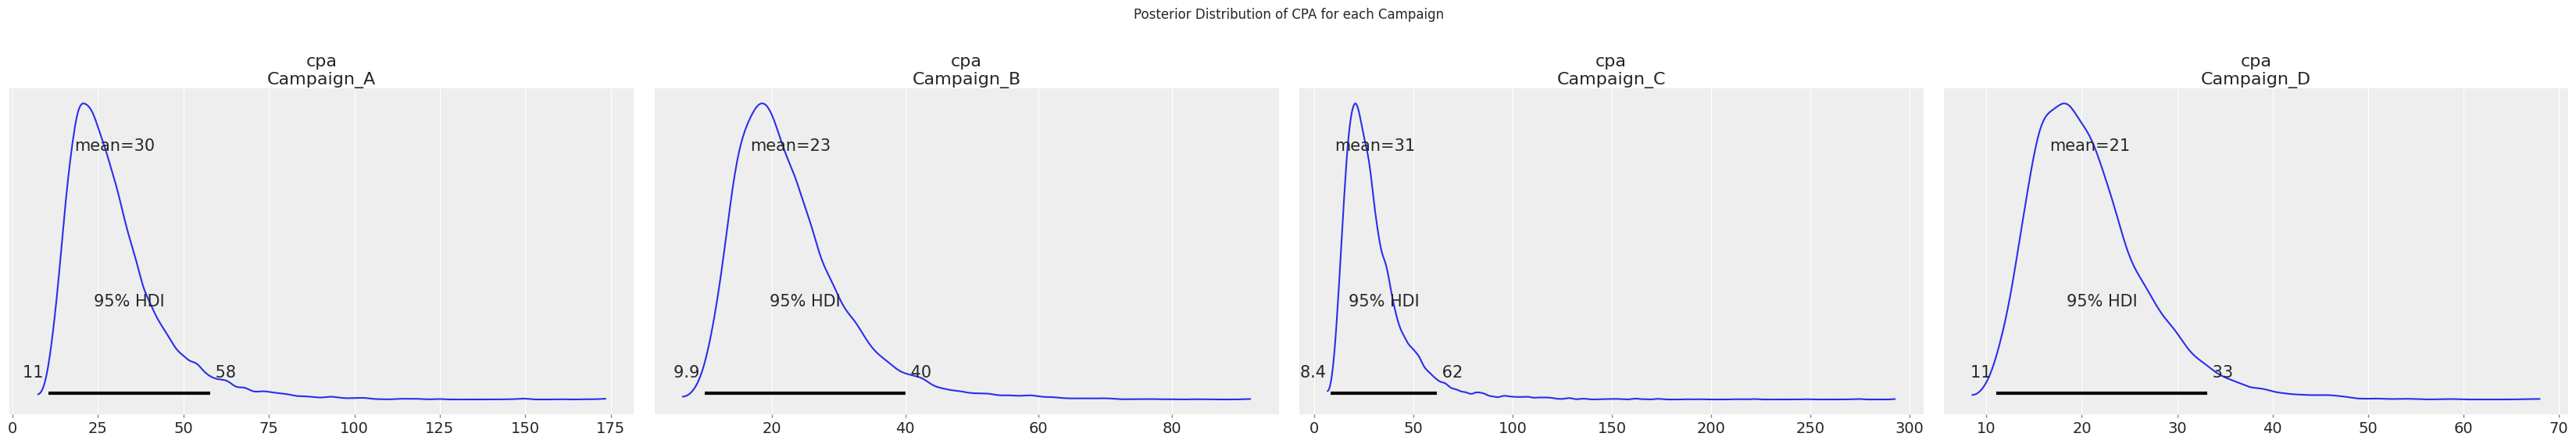


CPA Comparison Probabilities (Lower is Better):
* Probability Campaign A CPA < Campaign B CPA: 32.61%
* Probability Campaign D CPA < Campaign A CPA: 72.96%

Plotting Difference in CPA (A vs B)...


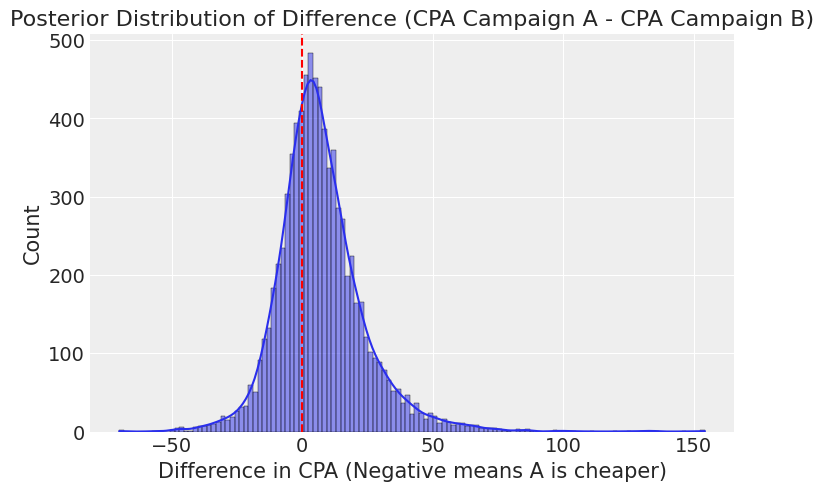


Probability CPA < Target ($50.00):
* Campaign A: 91.57%
* Campaign B: 98.60%
* Campaign D: 99.85%


In [ ]:
# @title Analysis: CPA Results Summary and Plots

# --- Analyze CPA Results ---
# Check if CPA was added to the trace
if 'cvr_trace' in locals() and cvr_trace is not None and 'cpa' in cvr_trace.posterior:
    # REMOVE: print("\n--- CPA Analysis ---") # Replaced by Markdown

    # 1. Summary Statistics (using the modified cvr_trace)
    print("\nCPA Posterior Summary (95% HDI):") # Keep print
    # Use round_to=2 for currency
    cpa_summary = az.summary(cvr_trace, var_names=["cpa"], hdi_prob=0.95, kind='all', round_to=2) # Use kind='all'
    print(cpa_summary)

    # 2. Visualize Posterior Distributions
    print("\nPlotting CPA Posteriors...") # Keep print
    az.plot_posterior(cvr_trace, var_names=["cpa"], hdi_prob=0.95)
    plt.suptitle("Posterior Distribution of CPA for each Campaign", y=1.02) # Add title
    plt.tight_layout()
    plt.show()

    # 3. Compare Campaigns (Lower is Better)
    print("\nCPA Comparison Probabilities (Lower is Better):") # Add print
    cpa_samples_all = cvr_trace.posterior['cpa']
    cpa_a_samples = cpa_samples_all.sel(campaign_cvr='Campaign_A').values.flatten()
    cpa_b_samples = cpa_samples_all.sel(campaign_cvr='Campaign_B').values.flatten()
    cpa_d_samples = cpa_samples_all.sel(campaign_cvr='Campaign_D').values.flatten() # Example

    prob_a_lt_b_cpa = (cpa_a_samples < cpa_b_samples).mean() # Probability A is CHEAPER than B
    print(f"* Probability Campaign A CPA < Campaign B CPA: {prob_a_lt_b_cpa:.2%}") # Use bullet points

    prob_d_lt_a_cpa = (cpa_d_samples < cpa_a_samples).mean() # Probability D is CHEAPER than A
    print(f"* Probability Campaign D CPA < Campaign A CPA: {prob_d_lt_a_cpa:.2%}") # Use bullet points
    # Add other relevant comparisons

    # Visualize the difference (A vs B)
    print("\nPlotting Difference in CPA (A vs B)...") # Keep print
    diff_a_b_cpa = cpa_a_samples - cpa_b_samples
    sns.histplot(diff_a_b_cpa, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title("Posterior Distribution of Difference (CPA Campaign A - CPA Campaign B)") # Descriptive title
    plt.xlabel("Difference in CPA (Negative means A is cheaper)") # Clearer label
    plt.ylabel("Count") # Add Y label
    plt.show()

    # 4. Probability CPA < Target
    cpa_target_value = 50.0 # Or get from config cell
    print(f"\nProbability CPA < Target (${cpa_target_value:.2f}):") # Add print
    prob_a_cpa_lt_target = (cpa_a_samples[np.isfinite(cpa_a_samples)] < cpa_target_value).mean() # Handle potential Inf
    prob_b_cpa_lt_target = (cpa_b_samples[np.isfinite(cpa_b_samples)] < cpa_target_value).mean()
    prob_d_cpa_lt_target = (cpa_d_samples[np.isfinite(cpa_d_samples)] < cpa_target_value).mean()

    print(f"* Campaign A: {prob_a_cpa_lt_target:.2%}")
    print(f"* Campaign B: {prob_b_cpa_lt_target:.2%}")
    print(f"* Campaign D: {prob_d_cpa_lt_target:.2%}") # Add others as needed

else:
    print("\nCPA Analysis skipped because CPA data was not found in cvr_trace.")

**Interpretation Notes (CPA):**

*   *(Copy the CPA interpretation bullet points from the `report_text_with_cpa` summary here, including the target probability)*
*   *(Copy the CPA comparison probabilities summary)*
*   Discuss uncertainty (HDI ranges). Emphasize which campaigns are likely *cheaper* (lower CPA) and the confidence level. Compare Campaign D (lowest mean CPA) vs others. Check if campaigns are meeting the target CPA probability threshold.

## 5. Return on Ad Spend (ROAS) Analysis (Optional)

### 5.1. Bayesian Model for ROAS

Finally, we model Return on Ad Spend (ROAS), defined as `Revenue / Spend`. This is often highly variable. We model the `Revenue` directly using a Gamma distribution, where the expected revenue (`mu`) is assumed to be proportional to `Spend` via the `expected_roas`.

*   **Priors:** We use weakly informative priors: `HalfNormal` for `expected_roas` (ensuring positivity) and `Exponential` for the Gamma distribution's `alpha` (shape) parameter, which allows for skewness common in revenue data.

In [ ]:
# @title Model: Define and Sample ROAS Model
# --- Bayesian Model for ROAS (via Revenue) ---
# Model: Revenue ~ Gamma(mu = expected_ROAS * spend, alpha)

# Filter out campaigns with 0 spend or 0 revenue for Gamma model
df_roas = df[(df['spend'] > 0) & (df['revenue'] > 0)].copy()

# Check if df_roas is empty
if df_roas.empty:
    print("WARNING: No campaigns with spend > 0 and revenue > 0 found. Skipping ROAS analysis.")
    roas_trace = None # Set trace to None
else:
    coords_roas = {"campaign_roas": df_roas['campaign_id'].values}

    with pm.Model(coords=coords_roas) as roas_model:
        # Data containers
        spend_data = pm.Data("spend_data", df_roas['spend'].values, mutable=True, dims="campaign_roas")
        revenue_data = pm.Data("revenue_data", df_roas['revenue'].values, mutable=True, dims="campaign_roas")

        # Priors (Weakly Informative)
        expected_roas = pm.HalfNormal("expected_roas", sigma=5, dims="campaign_roas")
        alpha = pm.Exponential("alpha", lam=0.5, dims="campaign_roas")

        # Model definition
        mu = pm.Deterministic("mu", expected_roas * spend_data, dims="campaign_roas")
        # PyMC Gamma uses alpha (shape) and beta (rate = alpha / mean)
        beta = pm.Deterministic("beta", alpha / mu, dims="campaign_roas")

        # Likelihood
        observed_revenue = pm.Gamma("observed_revenue",
                                    alpha=alpha,
                                    beta=beta,
                                    observed=revenue_data,
                                    dims="campaign_roas")

        # --- Run the MCMC Sampler ---
        print("Sampling ROAS (Revenue) model...")
        roas_trace = pm.sample(draws=2000, tune=2000, chains=4, target_accept=0.95)
        print("Sampling complete.")

        # --- REMOVE this summary ---
        # az.summary(roas_trace, var_names=["expected_roas", "alpha"])

Sampling ROAS (Revenue) model...


/usr/local/lib/python3.11/dist-packages/pymc/data.py:384: FutureWarning: Data is now always mutable. Specifying the `mutable` kwarg will raise an error in a future release
  warnings.warn(


Output()

Sampling complete.


### 5.2. ROAS Results and Interpretation

We analyze the `expected_roas` parameter from the model. ROAS results often have wide uncertainty due to revenue variability. The probability of exceeding a breakeven threshold (e.g., ROAS > 1.0) is often a key insight.


Expected ROAS Posterior Summary (95% HDI):
                            mean     sd  hdi_2.5%  hdi_97.5%  mcse_mean  \
expected_roas[Campaign_A]  3.699  2.217     0.496      8.168      0.029   
expected_roas[Campaign_B]  4.118  2.219     0.814      8.780      0.028   
expected_roas[Campaign_C]  3.208  2.233     0.289      7.827      0.029   
expected_roas[Campaign_D]  4.094  2.254     0.635      8.646      0.027   

                           mcse_sd  ess_bulk  ess_tail  r_hat  
expected_roas[Campaign_A]    0.033    5667.0    4703.0    1.0  
expected_roas[Campaign_B]    0.030    5773.0    4291.0    1.0  
expected_roas[Campaign_C]    0.032    5677.0    4649.0    1.0  
expected_roas[Campaign_D]    0.030    5980.0    4212.0    1.0  

Plotting Expected ROAS Posteriors...


<ipython-input-12-67223152a313>:16: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


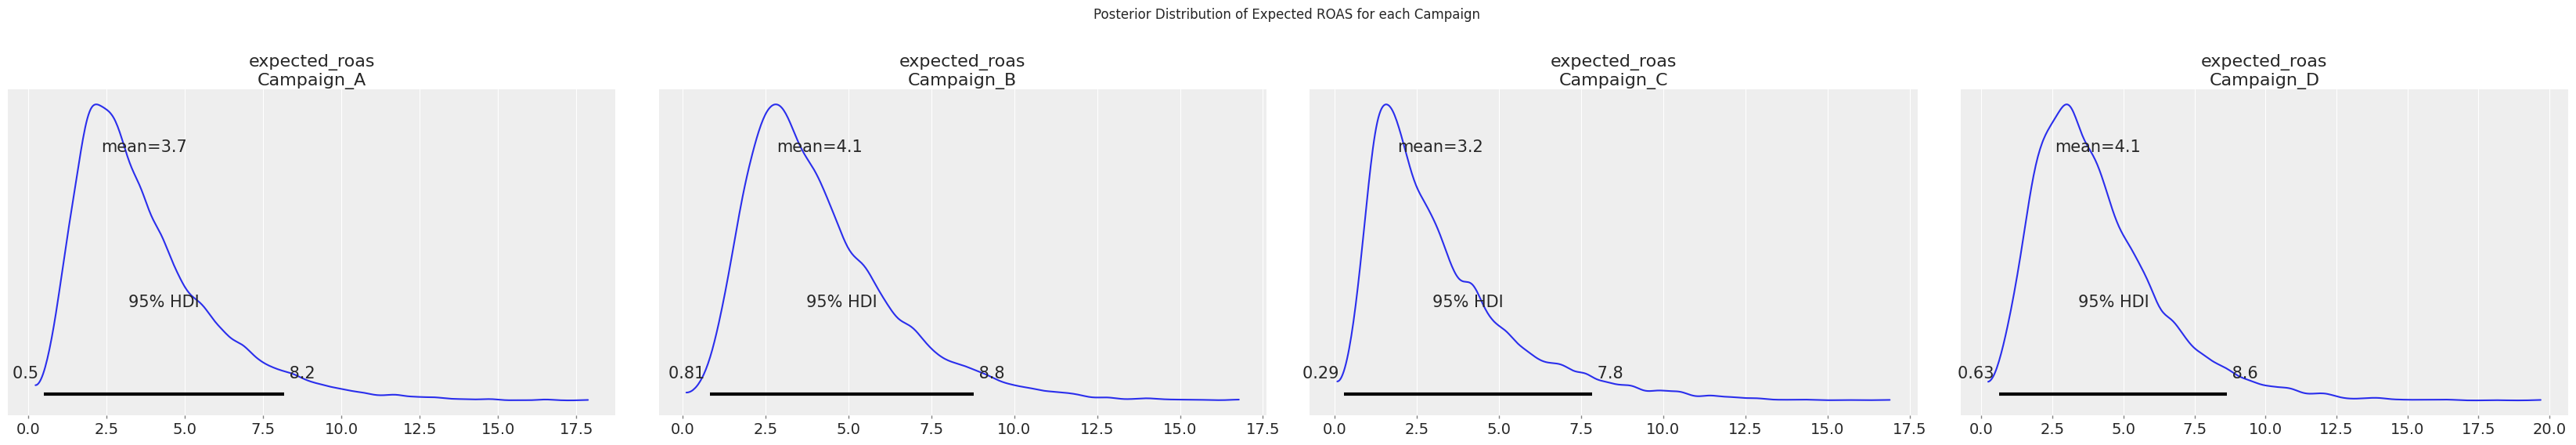


ROAS Comparison Probabilities:
* Probability Campaign B Expected ROAS > Campaign A Expected ROAS: 56.65%

Probability ROAS > Threshold (1.00):
* Campaign A: 97.14%
* Campaign B: 98.55%
* Campaign C: 92.65%
* Campaign D: 97.79%

Plotting Difference in Expected ROAS (B vs A)...


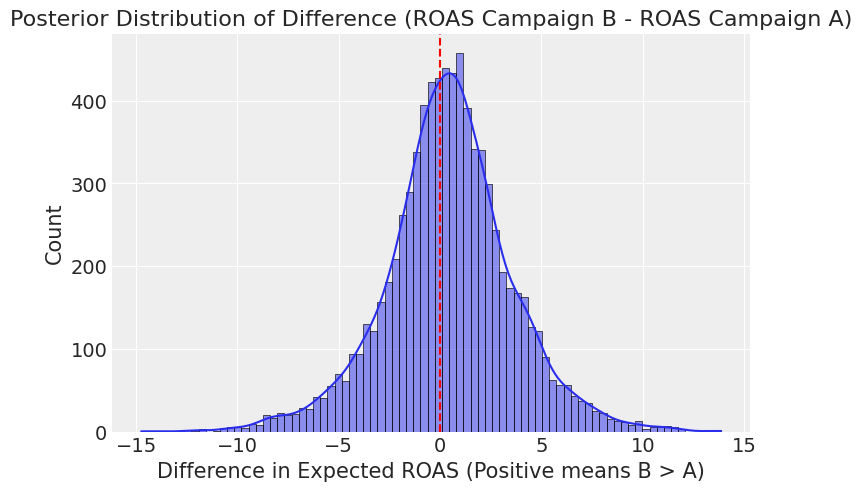

In [ ]:
# @title Analysis: ROAS Results Summary and Plots

# --- Analyze ROAS Results ---
if 'roas_trace' in locals() and roas_trace is not None:
    # REMOVE: print("\n--- ROAS Analysis ---") # Replaced by Markdown

    # 1. Summary Statistics for Expected ROAS
    print("\nExpected ROAS Posterior Summary (95% HDI):") # Keep print
    roas_summary = az.summary(roas_trace, var_names=["expected_roas"], hdi_prob=0.95, kind='all') # Use kind='all'
    print(roas_summary)

    # 2. Visualize Posterior Distributions
    print("\nPlotting Expected ROAS Posteriors...") # Keep print
    az.plot_posterior(roas_trace, var_names=["expected_roas"], hdi_prob=0.95)
    plt.suptitle("Posterior Distribution of Expected ROAS for each Campaign", y=1.02) # Add title
    plt.tight_layout()
    plt.show()

    # 3. Compare Campaigns
    print("\nROAS Comparison Probabilities:") # Add print
    roas_samples = roas_trace.posterior['expected_roas']
    roas_a_samples = roas_samples.sel(campaign_roas='Campaign_A').values.flatten()
    roas_b_samples = roas_samples.sel(campaign_roas='Campaign_B').values.flatten()
    # Add others if needed

    diff_b_a_roas = roas_b_samples - roas_a_samples
    prob_b_gt_a_roas = (diff_b_a_roas > 0).mean()
    print(f"* Probability Campaign B Expected ROAS > Campaign A Expected ROAS: {prob_b_gt_a_roas:.2%}") # Use bullet points
    # Add others if needed

    # 4. Probability ROAS > Threshold
    roas_threshold_value = 1.0 # Or get from config cell
    print(f"\nProbability ROAS > Threshold ({roas_threshold_value:.2f}):") # Add print
    prob_a_roas_gt_1 = (roas_a_samples > roas_threshold_value).mean()
    prob_b_roas_gt_1 = (roas_b_samples > roas_threshold_value).mean()
    prob_c_roas_gt_1 = (roas_samples.sel(campaign_roas='Campaign_C').values.flatten() > roas_threshold_value).mean()
    prob_d_roas_gt_1 = (roas_samples.sel(campaign_roas='Campaign_D').values.flatten() > roas_threshold_value).mean()

    print(f"* Campaign A: {prob_a_roas_gt_1:.2%}")
    print(f"* Campaign B: {prob_b_roas_gt_1:.2%}")
    print(f"* Campaign C: {prob_c_roas_gt_1:.2%}")
    print(f"* Campaign D: {prob_d_roas_gt_1:.2%}")

    # Visualize the difference
    print("\nPlotting Difference in Expected ROAS (B vs A)...") # Keep print
    sns.histplot(diff_b_a_roas, kde=True)
    plt.axvline(0, color='red', linestyle='--')
    plt.title("Posterior Distribution of Difference (ROAS Campaign B - ROAS Campaign A)") # Descriptive title
    plt.xlabel("Difference in Expected ROAS (Positive means B > A)") # Clearer label
    plt.ylabel("Count") # Add Y label
    plt.show()

    # --- REMOVE Trace Plotting - Move to separate cell at end ---
    # print("\nPlotting MCMC Trace for ROAS model...")
    # az.plot_trace(roas_trace, var_names=["expected_roas", "alpha"])
    # plt.tight_layout()
    # plt.show()
else:
    print("\nROAS Analysis skipped because roas_trace was not generated.")

**Interpretation Notes (ROAS):**

*   *(Copy the ROAS interpretation bullet points from the `report_text_with_cpa` summary here, including the threshold probability)*
*   *(Copy the ROAS comparison probabilities summary)*
*   Discuss the wide uncertainty. Focus on the probability of being profitable (ROAS > 1.0). Note which campaigns are statistically similar despite different means (e.g., B vs D).

In [ ]:
# @title Reporting: Define Interpretation Function (v4 with CPA)
import itertools
import warnings
import numpy as np # Needed for isnan check potentially

# --- Configuration (can be defined here or globally earlier) ---
# Make sure these are consistent with any global config cell if you added one earlier
HDI_PROB = 0.95
ROAS_THRESHOLD = 1.0
CPA_TARGET = 50.0
R_HAT_THRESHOLD = 1.05
ESS_THRESHOLD = 400

# --- Function to Check Diagnostics ---
def check_diagnostics_reinstated(summary_df, r_hat_thresh, ess_thresh):
    """Checks R-hat and ESS from an ArviZ summary DataFrame."""
    warnings_list = [] # Renamed from warnings to avoid conflict
    # Check if diagnostic columns EXIST before trying to access them
    has_rhat = 'r_hat' in summary_df.columns
    has_ess_bulk = 'ess_bulk' in summary_df.columns
    has_ess_tail = 'ess_tail' in summary_df.columns

    if not (has_rhat and has_ess_bulk and has_ess_tail):
         warnings_list.append("WARNING: Could not find one or more diagnostic columns (r_hat, ess_bulk, ess_tail) in the summary table.")
         warnings_list.append("         Manual diagnostic checks (e.g., az.plot_trace) are strongly recommended.")
         return warnings_list # Return early if columns are missing

    # Proceed with checks if columns exist
    # Handle potential NaN values in diagnostics before comparing
    max_rhat = summary_df['r_hat'].max()
    if not np.isnan(max_rhat) and max_rhat > r_hat_thresh:
        warnings_list.append(f"WARNING: Maximum R-hat ({max_rhat:.2f}) is above the threshold ({r_hat_thresh}). Results may be unreliable.")

    min_ess_bulk = summary_df['ess_bulk'].min()
    if not np.isnan(min_ess_bulk) and min_ess_bulk < ess_thresh:
        warnings_list.append(f"WARNING: Minimum Bulk Effective Sample Size ({min_ess_bulk:.0f}) is below the threshold ({ess_thresh}). Consider running the sampler longer.")

    min_ess_tail = summary_df['ess_tail'].min()
    if not np.isnan(min_ess_tail) and min_ess_tail < ess_thresh:
        warnings_list.append(f"WARNING: Minimum Tail Effective Sample Size ({min_ess_tail:.0f}) is below the threshold ({ess_thresh}). Consider running the sampler longer.")

    if len(warnings_list) == 0: # Check if any warnings were added
        # Use f-string formatting correctly for the success message
        return [f"Diagnostics check passed (R-hat <= {r_hat_thresh}, ESS >= {ess_thresh})."]
    else:
        return warnings_list

# --- Main Function to Generate Report Text ---
def generate_interpretation_report_with_cpa(df, ctr_trace=None, cvr_trace=None, roas_trace=None, hdi_prob=0.95, roas_threshold=1.0, cpa_target=50.0, r_hat_thresh=1.05, ess_thresh=400):
    """
    Generates interpretation, including derived CPA.
    (Version 4)
    """
    report = []
    hdi_lower_perc_str = f'hdi_{((1 - hdi_prob) / 2)*100:.1f}%'
    hdi_upper_perc_str = f'hdi_{(1 - (1 - hdi_prob) / 2)*100:.1f}%'
    hdi_level_str = f"{hdi_prob:.0%}"

    report.append("="*30)
    report.append("Bayesian Analysis Interpretation (v4 with CPA)")
    report.append("="*30 + "\n")
    report.append(f"Confidence Level for Intervals (HDI): {hdi_level_str}")
    report.append(f"ROAS Profitability Threshold: {roas_threshold:.2f}")
    report.append(f"CPA Target Threshold: ${cpa_target:.2f}") # Added CPA Target
    report.append(f"Diagnostic Thresholds: R-hat <= {r_hat_thresh}, ESS >= {ess_thresh}")
    report.append("-" * 30 + "\n")

    # --- CTR Analysis ---
    if ctr_trace:
        report.append("--- Click-Through Rate (CTR) Analysis ---")
        param_name = 'ctr'
        coord_name = 'campaign'
        try:
            with warnings.catch_warnings():
                 warnings.simplefilter("ignore", category=FutureWarning)
                 summary_ctr = az.summary(ctr_trace, var_names=[param_name], hdi_prob=hdi_prob, kind='all', filter_vars="like")
            diag_warnings = check_diagnostics_reinstated(summary_ctr, r_hat_thresh, ess_thresh)
            report.extend(diag_warnings) # Add warnings/success message

            if hdi_lower_perc_str not in summary_ctr.columns or hdi_upper_perc_str not in summary_ctr.columns:
                 report.append(f"ERROR: Expected HDI columns not found in CTR summary.")
            elif "Could not find one or more diagnostic columns" not in " ".join(diag_warnings):
                campaigns_in_trace = ctr_trace.posterior.coords[coord_name].values
                report.append("\nIndividual Campaign CTR Estimates:")
                for campaign in campaigns_in_trace:
                    idx_name = f"{param_name}[{campaign}]"
                    if idx_name in summary_ctr.index:
                         mean_ctr = summary_ctr.loc[idx_name, 'mean']
                         hdi_low = summary_ctr.loc[idx_name, hdi_lower_perc_str]
                         hdi_high = summary_ctr.loc[idx_name, hdi_upper_perc_str]
                         report.append(f"* {campaign}: Estimated CTR is {mean_ctr:.2%} ({hdi_level_str} likely between {hdi_low:.2%} and {hdi_high:.2%})")
                    else: report.append(f"* {campaign}: Summary data not found (check index: {idx_name})") # Added note
                report.append("\nCTR Comparisons:")
                ctr_samples = ctr_trace.posterior[param_name]
                for camp_a, camp_b in itertools.combinations(campaigns_in_trace, 2):
                    samples_a = ctr_samples.sel({coord_name: camp_a}).values.flatten()
                    samples_b = ctr_samples.sel({coord_name: camp_b}).values.flatten()
                    prob_a_gt_b = (samples_a > samples_b).mean()
                    report.append(f"* Probability {camp_a} CTR > {camp_b} CTR: {prob_a_gt_b:.1%}")
            report.append("\n" + "-" * 30 + "\n")
        except Exception as e: report.append(f"ERROR analyzing CTR: {e}\n" + "-" * 30 + "\n")

    # --- CVR Analysis ---
    if cvr_trace:
        report.append("--- Conversion Rate (CVR) Analysis (based on clicks) ---")
        param_name = 'cvr'
        coord_name = 'campaign_cvr'
        try:
            if param_name not in cvr_trace.posterior:
                 report.append("ERROR: 'cvr' variable not found in trace.")
            else:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=FutureWarning)
                    summary_cvr = az.summary(cvr_trace, var_names=[param_name], hdi_prob=hdi_prob, kind='all', filter_vars="like")
                diag_warnings = check_diagnostics_reinstated(summary_cvr, r_hat_thresh, ess_thresh)
                report.extend(diag_warnings)

                if hdi_lower_perc_str not in summary_cvr.columns or hdi_upper_perc_str not in summary_cvr.columns:
                     report.append(f"ERROR: Expected HDI columns not found in CVR summary.")
                elif "Could not find one or more diagnostic columns" not in " ".join(diag_warnings):
                    campaigns_in_trace = cvr_trace.posterior.coords[coord_name].values
                    report.append("\nIndividual Campaign CVR Estimates:")
                    for campaign in campaigns_in_trace:
                        idx_name = f"{param_name}[{campaign}]"
                        if idx_name in summary_cvr.index:
                            mean_cvr = summary_cvr.loc[idx_name, 'mean']
                            hdi_low = summary_cvr.loc[idx_name, hdi_lower_perc_str]
                            hdi_high = summary_cvr.loc[idx_name, hdi_upper_perc_str]
                            report.append(f"* {campaign}: Estimated CVR is {mean_cvr:.2%} ({hdi_level_str} likely between {hdi_low:.2%} and {hdi_high:.2%})")
                        else: report.append(f"* {campaign}: Summary data not found (check index: {idx_name})")
                    report.append("\nCVR Comparisons:")
                    cvr_samples = cvr_trace.posterior[param_name]
                    for camp_a, camp_b in itertools.combinations(campaigns_in_trace, 2):
                        samples_a = cvr_samples.sel({coord_name: camp_a}).values.flatten()
                        samples_b = cvr_samples.sel({coord_name: camp_b}).values.flatten()
                        prob_a_gt_b = (samples_a > samples_b).mean()
                        report.append(f"* Probability {camp_a} CVR > {camp_b} CVR: {prob_a_gt_b:.1%}")
            report.append("\n" + "-" * 30 + "\n")
        except Exception as e: report.append(f"ERROR analyzing CVR: {e}\n" + "-" * 30 + "\n")

    # --- CPA Analysis ---
    if cvr_trace: # CPA is derived from CVR trace
        report.append("--- Cost Per Acquisition (CPA) Analysis ---")
        param_name = 'cpa'
        coord_name = 'campaign_cvr'
        try:
            if param_name not in cvr_trace.posterior:
                 report.append("ERROR: 'cpa' variable not found in trace. Was the calculation cell run?")
            else:
                with warnings.catch_warnings():
                    warnings.simplefilter("ignore", category=FutureWarning)
                    summary_cpa = az.summary(cvr_trace, var_names=[param_name], hdi_prob=hdi_prob, kind='all', filter_vars="like", round_to=2)

                # Skip redundant diagnostic reporting for CPA as it relies on CVR trace

                if hdi_lower_perc_str not in summary_cpa.columns or hdi_upper_perc_str not in summary_cpa.columns:
                     report.append(f"ERROR: Expected HDI columns not found in CPA summary.")
                else:
                    campaigns_in_trace = cvr_trace.posterior.coords[coord_name].values
                    cpa_samples_all = cvr_trace.posterior[param_name]
                    report.append("\nIndividual Campaign CPA Estimates:")
                    for campaign in campaigns_in_trace:
                        idx_name = f"{param_name}[{campaign}]"
                        if idx_name in summary_cpa.index:
                            mean_cpa = summary_cpa.loc[idx_name, 'mean']
                            hdi_low = summary_cpa.loc[idx_name, hdi_lower_perc_str]
                            hdi_high = summary_cpa.loc[idx_name, hdi_upper_perc_str]
                            samples = cpa_samples_all.sel({coord_name: campaign}).values.flatten()
                            prob_lt_target = (samples[np.isfinite(samples)] < cpa_target).mean()
                            report.append(f"* {campaign}: Estimated CPA is ${mean_cpa:.2f} ({hdi_level_str} likely between ${hdi_low:.2f} and ${hdi_high:.2f}).")
                            report.append(f"  -> Probability CPA < ${cpa_target:.2f}: {prob_lt_target:.1%}")
                        else: report.append(f"* {campaign}: Summary data not found (check index: {idx_name})")
                    report.append("\nCPA Comparisons (Lower is Better):")
                    for camp_a, camp_b in itertools.combinations(campaigns_in_trace, 2):
                        samples_a = cpa_samples_all.sel({coord_name: camp_a}).values.flatten()
                        samples_b = cpa_samples_all.sel({coord_name: camp_b}).values.flatten()
                        prob_a_lt_b = (samples_a < samples_b).mean()
                        report.append(f"* Probability {camp_a} CPA < {camp_b} CPA: {prob_a_lt_b:.1%}")
            report.append("\n" + "-" * 30 + "\n")
        except Exception as e: report.append(f"ERROR analyzing CPA: {e}\n" + "-" * 30 + "\n")

    # --- ROAS Analysis ---
    if roas_trace:
        report.append("--- Return on Ad Spend (ROAS) Analysis ---")
        param_name = 'expected_roas'
        coord_name = 'campaign_roas'
        try:
            with warnings.catch_warnings():
                 warnings.simplefilter("ignore", category=FutureWarning)
                 summary_roas = az.summary(roas_trace, var_names=[param_name, 'alpha'], hdi_prob=hdi_prob, kind='all', filter_vars="like")
            # Filter summary to only check diagnostics for expected_roas
            summary_roas_filtered = summary_roas[summary_roas.index.str.contains(param_name)]
            diag_warnings = check_diagnostics_reinstated(summary_roas_filtered, r_hat_thresh, ess_thresh)
            report.extend(diag_warnings)

            if hdi_lower_perc_str not in summary_roas.columns or hdi_upper_perc_str not in summary_roas.columns:
                 report.append(f"ERROR: Expected HDI columns not found in ROAS summary.")
            elif "Could not find one or more diagnostic columns" not in " ".join(diag_warnings):
                campaigns_in_trace = roas_trace.posterior.coords[coord_name].values
                roas_samples_all = roas_trace.posterior[param_name]
                report.append("\nIndividual Campaign ROAS Estimates:")
                for campaign in campaigns_in_trace:
                    idx_name = f"{param_name}[{campaign}]"
                    if idx_name in summary_roas.index:
                        mean_roas = summary_roas.loc[idx_name, 'mean']
                        hdi_low = summary_roas.loc[idx_name, hdi_lower_perc_str]
                        hdi_high = summary_roas.loc[idx_name, hdi_upper_perc_str]
                        samples = roas_samples_all.sel({coord_name: campaign}).values.flatten()
                        prob_gt_thresh = (samples > roas_threshold).mean()
                        report.append(f"* {campaign}: Estimated ROAS is {mean_roas:.2f} ({hdi_level_str} likely between {hdi_low:.2f} and {hdi_high:.2f}).")
                        report.append(f"  -> Probability ROAS > {roas_threshold:.2f}: {prob_gt_thresh:.1%}")
                    else: report.append(f"* {campaign}: Summary data not found (check index: {idx_name})")
                report.append("\nROAS Comparisons:")
                for camp_a, camp_b in itertools.combinations(campaigns_in_trace, 2):
                    samples_a = roas_samples_all.sel({coord_name: camp_a}).values.flatten()
                    samples_b = roas_samples_all.sel({coord_name: camp_b}).values.flatten()
                    prob_a_gt_b = (samples_a > samples_b).mean()
                    report.append(f"* Probability {camp_a} ROAS > {camp_b} ROAS: {prob_a_gt_b:.1%}")
            report.append("\n" + "="*30 + "\n") # End of report marker
        except Exception as e: report.append(f"ERROR analyzing ROAS: {e}\n" + "="*30 + "\n")

    # Final reminder logic
    if "Could not find one or more diagnostic columns" in "\n".join(report):
         report.append("Reminder: Diagnostics columns missing. Always visually inspect trace plots (`az.plot_trace`) for convergence issues.")
    elif "WARNING:" in "\n".join(report):
         report.append("Reminder: Diagnostics warnings present. Visually inspect trace plots (`az.plot_trace`).")

    return "\n".join(report)

# Add a print statement to confirm the functions are defined
print("Interpretation function 'generate_interpretation_report_with_cpa' and 'check_diagnostics_reinstated' defined.")

Interpretation function 'generate_interpretation_report_with_cpa' and 'check_diagnostics_reinstated' defined.


## 6. Overall Summary Report Text

This section generates the consolidated text summary based on all the model results analyzed above.

In [ ]:
# @title Reporting: Generate and Print Summary Text Report
# --- Generate and Print the Updated Report ---
# Make sure df, ctr_trace, cvr_trace, roas_trace are available AND
# that the CPA calculation cell has been run to add 'cpa' to cvr_trace
print("Generating text report...")
report_text_with_cpa = generate_interpretation_report_with_cpa(
    df=df, # Explicitly name arguments for clarity
    ctr_trace=ctr_trace,
    cvr_trace=cvr_trace, # This trace now contains CVR and CPA
    roas_trace=roas_trace,
    hdi_prob=HDI_PROB,
    roas_threshold=ROAS_THRESHOLD,
    cpa_target=CPA_TARGET, # Pass the CPA target
    r_hat_thresh=R_HAT_THRESHOLD,
    ess_thresh=ESS_THRESHOLD
)

print(report_text_with_cpa)
# NO PLOTTING CODE SHOULD BE IN THIS CELL

Generating text report...
Bayesian Analysis Interpretation (v4 with CPA)

Confidence Level for Intervals (HDI): 95%
ROAS Profitability Threshold: 1.00
CPA Target Threshold: $50.00
Diagnostic Thresholds: R-hat <= 1.05, ESS >= 400
------------------------------

--- Click-Through Rate (CTR) Analysis ---
Diagnostics check passed (R-hat <= 1.05, ESS >= 400).

Individual Campaign CTR Estimates:
* Campaign_A: Estimated CTR is 2.00% (95% likely between 1.70% and 2.30%)
* Campaign_B: Estimated CTR is 1.80% (95% likely between 1.60% and 2.00%)
* Campaign_C: Estimated CTR is 2.10% (95% likely between 1.80% and 2.50%)
* Campaign_D: Estimated CTR is 2.20% (95% likely between 2.00% and 2.40%)

CTR Comparisons:
* Probability Campaign_A CTR > Campaign_B CTR: 86.8%
* Probability Campaign_A CTR > Campaign_C CTR: 26.9%
* Probability Campaign_A CTR > Campaign_D CTR: 14.3%
* Probability Campaign_B CTR > Campaign_C CTR: 4.5%
* Probability Campaign_B CTR > Campaign_D CTR: 1.0%
* Probability Campaign_C CTR >

## 7. MCMC Diagnostic Trace Plots (Appendix)

These plots help visually assess the convergence of the MCMC samplers. We look for:
*   **Left Plot (Posterior Density):** Smooth, unimodal distributions are good. Multiple peaks might indicate issues.
*   **Right Plot (Trace):** Should resemble a "fuzzy caterpillar" with different chains (colors) overlapping well and no long-term drifts or jumps. This indicates the sampler explored the distribution effectively.


--- CTR Trace Plot ---


<ipython-input-15-e9b0a30486df>:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


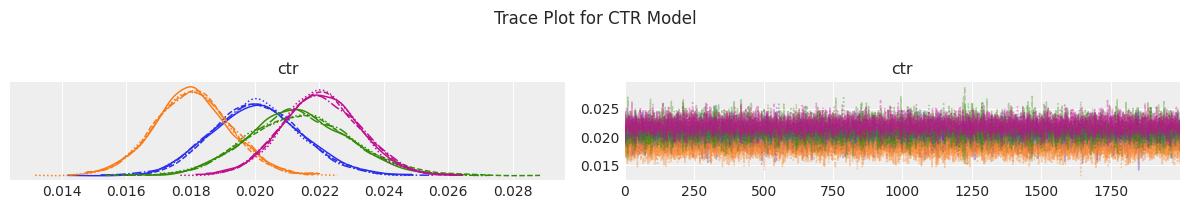

In [ ]:
# @title Diagnostics: CTR Trace Plot
# --- Plot CTR ---
print("\n--- CTR Trace Plot ---")
if 'ctr_trace' in locals() and ctr_trace is not None:
    try:
      az.plot_trace(ctr_trace, var_names=['ctr'])
      plt.suptitle("Trace Plot for CTR Model", y=1.02) # Add overall title
      plt.tight_layout()
      plt.show()
    except Exception as e:
      print(f"ERROR plotting CTR trace: {e}")
else:
    print("\nCTR trace plot skipped (trace object not found).")


--- CVR Trace Plot ---


<ipython-input-16-0f3d3330209b>:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


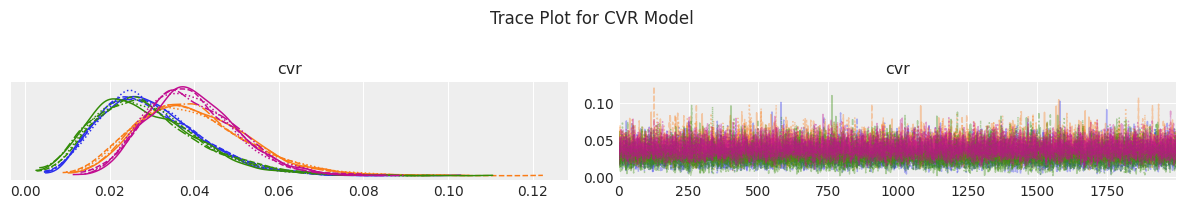

In [ ]:
# @title Diagnostics: CVR Trace Plot
# --- Plot CVR ---
print("\n--- CVR Trace Plot ---")
if 'cvr_trace' in locals() and cvr_trace is not None:
    try:
      az.plot_trace(cvr_trace, var_names=['cvr'])
      plt.suptitle("Trace Plot for CVR Model", y=1.02) # Add overall title
      plt.tight_layout()
      plt.show()
    except Exception as e:
      print(f"ERROR plotting CVR trace: {e}")
else:
    print("\nCVR trace plot skipped (trace object not found).")


--- ROAS Trace Plot ---


<ipython-input-17-ec45a9c85d64>:8: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


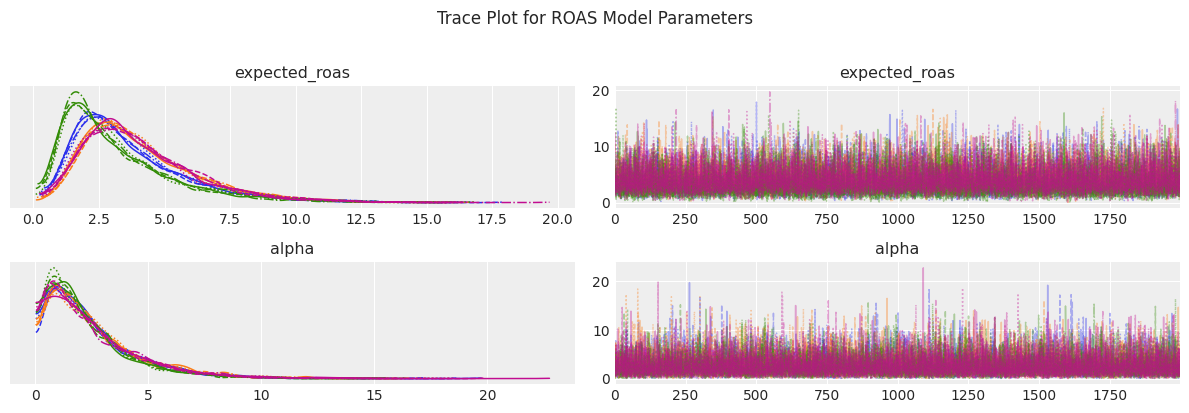

In [ ]:
# @title Diagnostics: ROAS Trace Plot
# --- Plot ROAS ---
print("\n--- ROAS Trace Plot ---")
if 'roas_trace' in locals() and roas_trace is not None:
    try:
      az.plot_trace(roas_trace, var_names=['expected_roas', 'alpha']) # Include alpha as well
      plt.suptitle("Trace Plot for ROAS Model Parameters", y=1.02) # Add overall title
      plt.tight_layout()
      plt.show()
    except Exception as e:
      print(f"ERROR plotting ROAS trace: {e}")
else:
    print("\nROAS trace plot skipped (trace object not found).")


--- CPA Trace Plot ---


<ipython-input-18-5d685e6e5a15>:9: UserWarning: The figure layout has changed to tight
  plt.tight_layout()


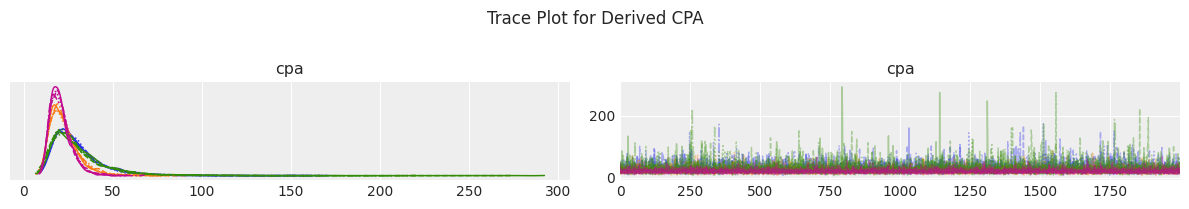

In [ ]:
# @title Diagnostics: CPA Trace Plot
# --- Plot CPA ---
print("\n--- CPA Trace Plot ---")
# Check trace exists AND cpa variable was added
if 'cvr_trace' in locals() and cvr_trace is not None and 'cpa' in cvr_trace.posterior:
    try:
      az.plot_trace(cvr_trace, var_names=['cpa']) # Plot CPA from the CVR trace
      plt.suptitle("Trace Plot for Derived CPA", y=1.02) # Add overall title
      plt.tight_layout()
      plt.show()
    except Exception as e:
      print(f"ERROR plotting CPA trace: {e}")
else:
    if 'cvr_trace' in locals() and cvr_trace is not None:
         print("\nCPA trace plot skipped ('cpa' variable not found in cvr_trace.posterior).")
    else:
         print("\nCPA trace plot skipped (cvr_trace object not found).")

## 8. Conclusions and Recommendations

*(This is where you synthesize the findings)*

*   **Key Metric Performance:** Briefly summarize the performance on CTR, CVR, and CPA for the top/bottom campaigns.
    *   *Example:* "Campaign D shows the strongest CTR and lowest (best) estimated CPA, although its CVR is statistically tied with Campaign B."
*   **Confidence & Uncertainty:** Mention where results are clear (high probability comparisons, narrow HDIs) and where uncertainty remains (probabilities near 50%, wide HDIs, especially for CVR/CPA/ROAS).
*   **Actionable Insights:** Based on the probabilities and targets, what actions are recommended?
    *   *Example:* "Given the >99% probability that Campaign D's CPA is below target and its strong CTR, we recommend prioritizing budget towards it. Campaign B also performs well on CPA and CVR and warrants continued investment. Campaign C shows lower performance and higher uncertainty, suggesting potential optimization or budget reduction."
*   **Next Steps:** Any further analysis needed? Different data segments to explore?

In [ ]:
# @title Reporting: Convert Notebook to Clean HTML Report

# --- STEP 1: Mount Google Drive (if not already mounted) ---
# ...(Mount code)...

# --- STEP 2: DEFINE NOTEBOOK PATH (!!! CHANGE THIS IF NEEDED !!!) ---
# This STILL needs to point to the .ipynb file itself
# It might be the same as PROJECT_DIR + "/1. Code Notebooks/YourNotebookName.ipynb"
# Or adjust if you saved copies elsewhere.
notebook_path_in_drive = "/content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)/1. Code Notebooks/Savvly Bayesian Ads_ver.2.0.ipynb" # <--- UPDATE IF YOUR NOTEBOOK PATH CHANGED

# --- STEP 3: Use paths defined in the Configuration Cell ---
# These variables should exist if the config cell was run:
# OUTPUT_REPORT_HTML (contains the full desired path and filename for the report)
# PROJECT_DIR (used to find the output folder)

# Temporary path in Colab
temp_html_output_path = f"/content/{OUTPUT_REPORT_HTML.split('/')[-1]}" # Extract filename

# --- STEP 4: Run nbconvert ---
print(f"\nAttempting to convert '{notebook_path_in_drive}' to HTML...")
print(f"Temporary output will be: '{temp_html_output_path}'")


!jupyter nbconvert --to html --template classic --no-input --ClearMetadataPreprocessor.enabled=True "{notebook_path_in_drive}" --output "{temp_html_output_path}"

print("\nConversion process finished.")

# --- STEP 5: Verify and Copy to Drive ---
import os
if os.path.exists(temp_html_output_path):
    print(f"\nSUCCESS! HTML report generated at: {temp_html_output_path}")
    print("You can download it directly from the Colab file browser.")

    # Use the full OUTPUT_REPORT_HTML path for copying
    print(f"\nAttempting to copy report to Google Drive: '{OUTPUT_REPORT_HTML}'...")
    try:
        # Extract destination folder from the full path
        destination_folder = os.path.dirname(OUTPUT_REPORT_HTML)
        # Ensure the destination folder exists (optional but good practice)
        if not os.path.exists(destination_folder):
             print(f"WARNING: Destination folder '{destination_folder}' might not exist. Attempting copy anyway.")
        # Copy the file using the full destination path
        !cp "{temp_html_output_path}" "{OUTPUT_REPORT_HTML}"
        if os.path.exists(OUTPUT_REPORT_HTML):
             print("SUCCESS! Report copied to Google Drive.")
        else:
             print("WARNING: Report file not found in Google Drive after copy attempt. Check paths.")
    except Exception as e:
        print(f"ERROR copying file to Google Drive: {e}")
else:
    print(f"\nERROR: HTML report file was not found at '{temp_html_output_path}'. Check nbconvert output.")


Attempting to convert '/content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)/1. Code Notebooks/Savvly Bayesian Ads_ver.2.0.ipynb' to HTML...
Temporary output will be: '/content/Report_2023-11-30.html'
[NbConvertApp] Converting notebook /content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)/1. Code Notebooks/Savvly Bayesian Ads_ver.2.0.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 12 image(s).
[NbConvertApp] Writing 1800598 bytes to /content/Report_2023-11-30.html

Conversion process finished.

SUCCESS! HTML report generated at: /content/Report_2023-11-30.html
You can download it directly from the Colab file browser.

Attempting to copy report to Google Drive: '/content/drive/MyDrive/Colab Notebooks/Bayesian Ad Analysis (SAVVLY)/3. Reports/Report_2023-11-30.html'...
SUCCESS! Report copied to Google Drive.
